- Reference:[https://www.kaggle.com/yamqwe/time-series-modeling-lstm](https://www.kaggle.com/yamqwe/time-series-modeling-lstm)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
##data and date
dat = pd.read_csv('./data/train.csv')
dat = dat.set_index('timestamp')
info = pd.read_csv('./data/asset_details.csv')
assets_names = dict(zip(info.Asset_ID, info.Asset_Name))
dat['Asset_name'] = dat.Asset_ID.map(assets_names)
dat['asset_count'] = 1
#should be 14 for each timestamp when consistant
dat['asset_count'] = dat.groupby(by = dat.index)['asset_count'].sum()
dat.head()
all_same_time = dat[dat['asset_count'] == 14]
all_same_time = all_same_time.drop('asset_count',axis=1)
all_same_time.head()
## Target correlation map
corr_target = all_same_time.reset_index().pivot(index = 'Asset_name', columns = 'timestamp')['Target'].transpose().corr()
fig, ax = plt.subplots(figsize = (20, 8))
sns.heatmap(np.round(corr_target, 2), annot = True, ax = ax, square = True)
del all_same_time
del dat
gc.collect()

## LSTM model

## configure

In [1]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.config.list_physical_devices())

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

pd.set_option('display.max_columns', None)
from script.LSTM.configure import *


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
N_ASSETS = 14, WINDOW_SIZE =15, BATCH_SIZE = 1024,EPOCHS = 20,PCT_VALIDATION=10
connecting to TPU...
Num GPUs Available:  1


### data loading

- choose which years to load

In [2]:
from script.LSTM.dataload import load_data_for_all_assets
train = load_data_for_all_assets(load_jay = True, includeextra=True)
train = train.sort_values('timestamp').set_index("timestamp")
if DEBUG: train = train[10000000:]

select years INC2021
select years INC2020
loading preparing


### asset order,name,weight
`train.csv` asset order is not same as `supplemental_train.csv`

In [3]:
test = pd.read_csv('./data/' + 'example_test.csv')
#asset name, weight
assets = pd.read_csv('./data/asset_details.csv')
assets_names = dict(zip(assets.Asset_ID, assets.Asset_Name))
train['Asset_Name'] = train.Asset_ID.map(assets_names)
assets_weight = dict(zip(assets.Asset_ID, assets.Weight))
train['Weight'] = train.Asset_ID.map(assets_weight)

#the order of the cryptos collected at same timestamp.
assets_order = pd.read_csv('./data/supplemental_train.csv').Asset_ID[:N_ASSETS]
assets_order = dict((t,i) for i,t in enumerate(assets_order))
print(f"Loaded all data range {train.index.values.astype('datetime64[s]')[[0,-1]]}")

Loaded all data range ['2021-06-05T02:12:00' '2021-11-22T23:43:00']


## feature encoding

- Upper_Shadow, Lower_Shadow,spread,mean_trade,log_price_change

In [4]:
train.columns

Index(['Asset_ID', 'Asset_Name', 'Weight', 'Count', 'Open', 'High', 'Low',
       'Close', 'Volume', 'VWAP', 'Target', 'date'],
      dtype='object')

In [5]:
from script.LSTM.encodefeature import get_features
## Target fillin
train['Target'] = train['Target'].fillna(0)
#VWAP make finite
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)

#timestamp order into train[['id','group_num']] later
df = train[['Asset_ID', 'Target']].copy()
times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()# timestamp id before non-real fillin
del df
## make new features
train = get_features(train)
train_features = [i for i in train.columns if i not in ['Target', 'date', 'timestamp', 'Asset_ID', 'Asset_Name','Weight','groups']]

In [6]:
train.columns

Index(['Asset_ID', 'Asset_Name', 'Weight', 'Count', 'Open', 'High', 'Low',
       'Close', 'Volume', 'VWAP', 'Target', 'date', 'Upper_Shadow',
       'Lower_Shadow', 'spread', 'mean_trade', 'log_price_change'],
      dtype='object')

### missing data

In [7]:
train = train.sort_index()
ind = train.index.unique()

def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
#all aassets has same timestamps with missing fillin
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
gc.collect()
train.shape

(3445288, 17)

In [8]:
# Matching records and marking generated rows as 'non-real' for masking layer
train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')
train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)
train['is_real'] = train.id.isin(ids) * 1 #identify non-real fill in
train = train.drop('id', axis=1)

# Features values for 'non-real' rows are set to zeros
features = train.columns.drop(['Asset_ID','group_num','is_real'])
train.loc[train.is_real == 0, features] = 0.

## sort the data by time and asset_id_order
from script.memory_usage import reduce_mem_usage
train['asset_order'] = train.Asset_ID.map(assets_order)
train = train.sort_values(by=['group_num', 'asset_order'])
train = reduce_mem_usage(train)
gc.collect()

Memory usage of dataframe is 381.11 MB
Memory usage after optimization is: 256.26 MB
Decreased by 32.8%


0

In [9]:
train.columns

Index(['Asset_ID', 'Asset_Name', 'Weight', 'Count', 'Open', 'High', 'Low',
       'Close', 'Volume', 'VWAP', 'Target', 'date', 'Upper_Shadow',
       'Lower_Shadow', 'spread', 'mean_trade', 'log_price_change', 'group_num',
       'is_real', 'asset_order'],
      dtype='object')

## 3D arrays for train/test

In [10]:
#make 3D-numpy arrays for train and targets
targets = train['Target'].to_numpy().reshape(-1, N_ASSETS)

In [11]:
features = train.columns.drop(['Asset_ID', 'Asset_Name','Weight', 'Target', 'group_num', 'is_real', 
                                'date','asset_order'])
features

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Upper_Shadow', 'Lower_Shadow', 'spread', 'mean_trade',
       'log_price_change'],
      dtype='object')

In [12]:
train = train[features].values
train = train.reshape(-1, N_ASSETS, train.shape[-1])

In [13]:
print(targets.shape[0] == train.shape[0])
print(targets.shape, train.shape)
gc.collect()

True
(246071, 14) (246071, 14, 12)


0

In [14]:
X_train, X_test = train[:-len(train)//PCT_VALIDATION], train[-len(train)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train)//PCT_VALIDATION], targets[-len(train)//PCT_VALIDATION:]

In [15]:
X_train.shape, y_train.shape
#timestamp, asset_num, feature_numb

((221463, 14, 12), (221463, 14))

### dataset windowing

Samples with a duration of `WINDOW_SIZE` records (minutes) will be formed from the train array. Each sample has a target vector corresponding to the final index if `WINDOW_SIZE` record.

In [16]:
from script.LSTM.datasetwindow import sample_generator
train_generator = sample_generator(X_train, y_train, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
print(f'Sample shape: {train_generator[0][0].shape}')#batch_0, window, n_assets, features
print(f'Target shape: {train_generator[0][1].shape}')#batch_0, N_ASSETS

Sample shape: (1024, 15, 14, 12)
Target shape: (1024, 14)


## Compiling model

Our model will be trained for the number of `FOLDS` and `EPOCHS` you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict `OOF`(Out of fold) and test. 

Because of the nature of this competition, we will implement the idea of using the parallel sequence model branches. One for for each asset to then use the represenation learned to output a vector of targets for each timestep.

In [17]:
# paste the module trainmodel here for kaggle use issue
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
from tensorflow import keras
########################custom metrics
def MaxCorrelation(y_true,y_pred): 
    return -tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))
def Correlation(y_true,y_pred): 
    return tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))
##########################custom loss func
def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_mae(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_absolute_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_cosine(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)
############################define lstm layer
def get_squence_model(x):
    x = layers.LSTM(units=32, return_sequences=True)(x)
    return x

############################compile model
def get_model(n_assets = 14, trainshape=(15,14,12)):
    #Keras tensor
    x_input = keras.Input(shape=trainshape)
    ## parallel sequence model branches
    branch_outputs = []
    for i in range(n_assets):
        # Slicing the ith asset: x_input into x of the lambda function
        a = layers.Lambda(lambda x: x[:,:, i])(x_input) #lambda layer
        a = layers.Masking(mask_value = 0., )(a) #masking layer
        #a = get_squence_model(a)#lstm layer
        a = layers.LSTM(units=32, return_sequences=True)(a)
        a = layers.GlobalAvgPool1D()(a)#globalavgpool layer
        branch_outputs.append(a)
    
    x = layers.Concatenate()(branch_outputs)
    x = layers.Dense(units = 128)(x)#dense layer 0
    out = layers.Dense(units = n_assets)(x)#dense layer 1
    model = keras.Model(inputs=x_input, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
                    loss = masked_cosine, metrics=[Correlation])
    return model

In [18]:
#from script.LSTM.trainmodel import get_model
model = get_model(n_assets=14,
                trainshape=(train_generator[0][0].shape[1], 14, train_generator[0][0].shape[-1]))
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-11-27 17:18:25.960771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-27 17:18:25.960909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 14, 12)] 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 15, 12)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 15, 12)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 15, 12)       0           input_1[0][0]                    
______________________________________________________________________________________________

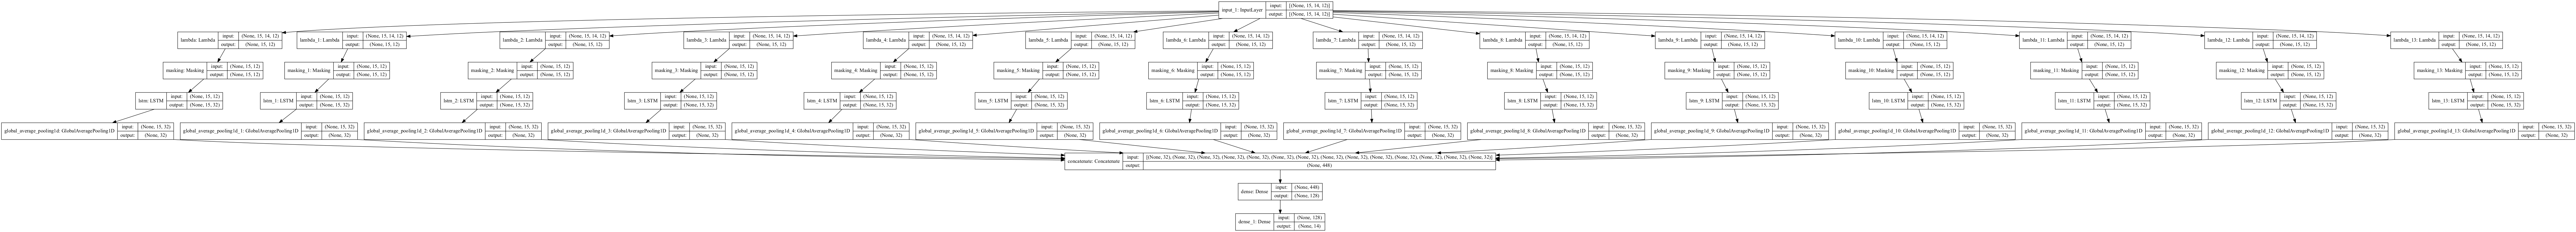

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True,to_file='./pic/lstm-kaggle.png')

## Fitting model

In [20]:
print(features)
tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 0, mode = 'min',restore_best_weights = True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

history = model.fit(train_generator, validation_data = (val_generator), 
                    epochs = EPOCHS, callbacks = [lr, estop])
model.save("./trainedNN/kaggleLSTM")

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Upper_Shadow', 'Lower_Shadow', 'spread', 'mean_trade',
       'log_price_change'],
      dtype='object')
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).


2021-11-27 17:18:29.839807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-27 17:18:29.839950: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-27 17:18:39.596969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:18:41.169289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:18:41.274656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:18:41.382949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:18:41.489336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

217/217 [==============================] - ETA: 0s - loss: -0.0016 - Correlation: 0.0245

2021-11-27 17:21:35.474541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:21:36.183514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:21:36.227776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:21:36.289686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:21:36.349420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:21:36.403693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 17:21:36.459308: I tensorflow/core/grappler/optimizers/cust

217/217 [==============================] - 189s 809ms/step - loss: -0.0016 - Correlation: 0.0245 - val_loss: -0.0047 - val_Correlation: 0.0239
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00093811745, shape=(), dtype=float32).
217/217 [==============================] - 168s 775ms/step - loss: -0.0072 - Correlation: 0.0231 - val_loss: -0.0045 - val_Correlation: 0.0268
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0008800643, shape=(), dtype=float32).
217/217 [==============================] - 162s 749ms/step - loss: -0.0092 - Correlation: 0.0248 - val_loss: -0.0048 - val_Correlation: 0.0245
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0008256038, shape=(), dtype=float32).
217/217 [==============================] - 160s 739ms/step - loss: -0.0099 - Correlation: 0.0238 - val_loss: -0.0053 - val_Correlation: 0.0275
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learni

2021-11-27 18:13:24.683283: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: kaggleLSTM/assets


INFO:tensorflow:Assets written to: kaggleLSTM/assets


In [21]:
#crypto order at same timestamp in the aftergame train data
from script.LSTM.encodefeature import get_features
data_path = './data'
sup_train=pd.read_csv(data_path+'/supplemental_train.csv')
assets_order = dict((t,i) for i,t in enumerate(sup_train.Asset_ID[:N_ASSETS]))
features = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Upper_Shadow', 'Lower_Shadow', 'spread', 'mean_trade',
       'log_price_change']
#first 15mins samples(15*14=210 rows)
placeholder = get_features(sup_train[:WINDOW_SIZE * (N_ASSETS)])
pd.options.mode.chained_assignment = None  # default='warn'
placeholder['asset_order'] = placeholder.Asset_ID.map(assets_order)
# shape into our model's one sample of 15minutes input array
test_x = np.array(placeholder[features])
test_x = test_x.reshape(-1, (N_ASSETS), test_x.shape[-1])
print(test_x.shape)
test_x = np.expand_dims(test_x, axis=0) #additional dimension for one sample in a batch


(15, 14, 12)


/Users/dingxian/Documents/GitHub/Crypto_Forecasting_kaggle/script/LSTM/encodefeature.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
/Users/dingxian/Documents/GitHub/Crypto_Forecasting_kaggle/script/LSTM/encodefeature.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
/Users/dingxian/Documents/GitHub/Crypto_Forecasting_kaggle/script/LSTM/encodefeature.py:7: SettingW

In [22]:
model.predict(test_x)

2021-11-27 18:13:45.148520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:13:45.874565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:13:45.917714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:13:45.968150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:13:46.028763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:13:46.074133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:13:46.121616: I tensorflow/core/grappler/optimizers/cust

array([[ 2.032953  , -0.570059  ,  0.47823888, -0.60007596, -3.2512867 ,
        -0.22999956, -0.19391565,  0.18479799,  1.9907687 , -2.8473687 ,
        -3.7851593 ,  3.6182704 , -2.2789295 ,  4.3256197 ]],
      dtype=float32)

In [23]:
#from script.LSTM.trainmodel import *
reloadmodel = keras.models.load_model("./trainedNN/kaggleLSTM",custom_objects={"masked_cosine": masked_cosine, 
                                                    'Correlation':Correlation})
reloadmodel.predict(test_x)

2021-11-27 18:13:50.486521: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-11-27 18:13:50.492821: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-11-27 18:13:50.862726: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-11-27 18:13:50.877571: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-11-27 18:13:50.883534: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

array([[ 2.032953  , -0.570059  ,  0.47823888, -0.60007596, -3.2512867 ,
        -0.22999956, -0.19391565,  0.18479799,  1.9907687 , -2.8473687 ,
        -3.7851593 ,  3.6182704 , -2.2789295 ,  4.3256197 ]],
      dtype=float32)

In [33]:
with open('./data/temp/test_x.npy', 'rb') as f:
    kaggle_test_x = np.load(f)
reloadmodel.predict(kaggle_test_x)

array([[ 2.032953  , -0.570059  ,  0.47823888, -0.60007596, -3.2512867 ,
        -0.22999956, -0.19391565,  0.18479799,  1.9907687 , -2.8473687 ,
        -3.7851593 ,  3.6182704 , -2.2789295 ,  4.3256197 ]],
      dtype=float32)

## Evaluation

/var/folders/_0/sgv1wmb92l11hndgfl0tyvjr0000gn/T/ipykernel_9794/875232677.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


810

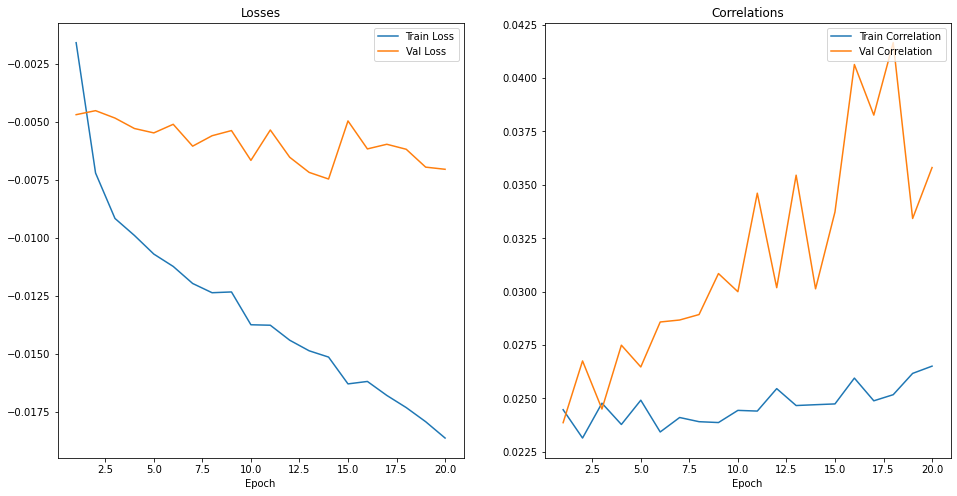

In [25]:

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
histories = pd.DataFrame(history.history)
epochs = list(range(1,len(histories)+1))
loss = histories['loss']
val_loss = histories['val_loss']
Correlation = histories['Correlation']
val_Correlation = histories['val_Correlation']
ax[0].plot(epochs, loss, label = 'Train Loss')
ax[0].plot(epochs, val_loss, label = 'Val Loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')
ax[1].plot(epochs, Correlation, label = 'Train Correlation')
ax[1].plot(epochs, val_Correlation, label = 'Val Correlation')
ax[1].set_title('Correlations')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')
fig.show()
gc.collect()

In [26]:
# The correlation coefficients by asset for the validation data
predictions = model.predict(val_generator)

print('Asset:    Corr. coef.')
print('---------------------')
for i in range(N_ASSETS):
    # drop first 14 values in the y_test, since they are absent in val_generator labels
    y_true = np.squeeze(y_test[WINDOW_SIZE - 1:, i])
    y_pred = np.squeeze(predictions[:, i])
    real_target_ind = np.argwhere(y_true!=0)
    asset_id = list(assets_order.keys())[i]
    asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
    print(f"{asset_name}: {np.corrcoef(y_pred[real_target_ind].flatten(), y_true[real_target_ind].flatten())[0,1]:.4f}")

2021-11-27 18:14:13.120998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:14:13.857203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:14:13.919215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:14:14.017909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:14:14.083992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:14:14.143050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 18:14:14.205361: I tensorflow/core/grappler/optimizers/cust

Asset:    Corr. coef.
---------------------
Cardano: 0.0205
Bitcoin Cash: 0.0187
Binance Coin: 0.0024
Bitcoin: -0.0216
Dogecoin: 0.0186
EOS.IO: 0.0103
Ethereum Classic: -0.0067
Ethereum: -0.0269
IOTA: -0.0083
Litecoin: -0.0149
Maker: -0.0020
TRON: 0.0234
Stellar: 0.0173
Monero: 0.0106
